# Cumulative Regret Plots

This is mostly copy/paste from `./notebook.ipynb` modified to plot Cumulative Regret instead of Simple Regret.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'

def latexify(fig_width=None, fig_height=None, columns=3):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2,3])

    # width in inches
    if fig_width is None:
        if columns==1:
            fig_width = 6.9
        elif columns==2:
            fig_width = 3.39 
        else:
            fig_width = 2.2

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pgf',
              'pgf.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              #'font.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [2]:
import matplotlib.pyplot as plt
import os
import argparse
from ast import literal_eval
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from dateutil import parser

import pandas as pd
import numpy as np

from run import create_model
import config
from src.utils import accumulate_immediate_regret as acc_ir, plot_immediate_regret as plot_ir, immediate_regret as immidiate_regret

df_indexed = None

conf = config.get_config()
df = pd.read_csv(conf['database'])

# Only take the once with 200 iterations
# df = df[df.num_steps == 200]

# Parse arrays
df['activations'] = df.activations.fillna('None').apply(literal_eval).apply(tuple)
df['incumbent'] = df.incumbent.fillna('None').apply(literal_eval)
df['immediate_regret'] = df.immediate_regret.fillna('None').apply(literal_eval)
df.date = df.date.astype('datetime64[ns]')

# Remove invalid seeds (set default seed)
# df.loc[df.seed == -1, 'seed'] = 0

# Remove dublicates
df = df.sort_values(by=['date'])
df = df.groupby(["uuid"]).agg(lambda x: x.iloc[0]).reset_index()
df = df.sort_values(by=['date'])

# Make embedding into tuples to support hashing (used in groupby)
df.embedding = df.embedding.fillna('[]')
df.embedding = df.embedding.apply(literal_eval)
df.embedding = [ tuple(row.embedding) for _, row in df.iterrows() ]

def get_model_conf(uid):
    row = df_indexed.loc[uid]
    model_shortname = row['name']
    model_conf = config.get_model_config(uid, model_shortname, conf)
    return model_conf

def plot_ir_image(model_conf):
    display(Image(filename=model_conf['regret_plot_path']))

def plot_step_image(model_conf):
    # l = os.listdir(model_conf['plot_folder'])
    l_all = glob.glob(os.path.join(model_conf['plot_folder'], '*.png'))
    l_all.sort(key=lambda n: int(n.replace(".", "-").split('-')[-2]))
    l_em = [img for img in l_all if "embedding" in img]
    l = [img for img in l_all if "embedding" not in img]

    def show_image(i):
        if i < len(l):
            display(Image(filename=l[i]))
        if i < len(l_em):
            display(Image(filename=l_em[i]))
    
    length = max(len(l), len(l_em))
    # Only if there are images
    if length > 0:
        interact(show_image, i=widgets.IntSlider(min=0, max=length - 1, step=1, value=0))

def get_XY(model_conf):
    X = np.load(model_conf['obs_X_path'])
    Y = np.load(model_conf['obs_Y_path'])
    return X, Y
    
def recreate_model(uid, model_conf, train=True, extra_args=None):
    args_dict = df_indexed.loc[uid].to_dict()
    if extra_args is not None:
        args_dict.update(extra_args)
        
    args = argparse.Namespace(**args_dict)
    args.batch_size = int(args.batch_size) # quick fix
    #args.seed = int(args.seed)             # quick fix
    args.seed = None
        
    bo = create_model(args)
    X,Y = get_XY(model_conf)
    bo.model.init(X, Y, train=train)
    return bo

import itertools
def get_regret_history(uids):
    max_hist = []
    for uid in uids:
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        
        maxy = bo.model.Y

        # Remove output dimension
        maxy = maxy[:,0]
        max_hist.append(maxy)
    # Fills arrays of different length with NaN
    max_hist = np.array(list(itertools.zip_longest(*max_hist, fillvalue=np.nan))).T
    
    f_opt = bo.f_opt if bo.f_opt is not None else 0
    # top = np.maximum(mean + np.sqrt(var), bo.f_opt)
    # bottom = np.maximum(mean - np.sqrt(var), bo.f_opt)
    #return np.abs(mean + np.sqrt(var) - f_opt), np.abs(mean - f_opt), np.abs(mean - np.sqrt(var) - f_opt), max_hist
    return f_opt, max_hist

# Give correct type (pytorch does not allow numpy.float64 and numpy.int64)
for col in ['dim_basis', 'dim_h1', 'dim_h2', 'num_nn', 'batch_size', 'epochs', 'num_mcmc', 'n_iter', 'n_init']:
    df[col] = df[col].astype(int)
for col in ['lr', 'weight_decay']:
    df[col] = df[col].astype(float)


df_indexed = df.set_index('uuid')


df.loc[df.group.isin(['funcs', 'funcs1', 'funcs2', 'funcs3', 'funcs4']), 'group'] = 'funcs'
df.loc[df.group.isin(['epoch', 'epoch2']), 'group'] = 'epoch'

df.init_src = df.init_src.fillna('')

# Group the same model and calc regret history
# TODO: add seed
uuid_keys = ['acq', 'batch_size', 'dim_basis', 'dim_h1', 'dim_h2',
         'epochs', 'lr', 'model', 'n_iter', 'nn_aggregator', 'num_mcmc', 'num_nn',
         'weight_decay', 'obj_func', 'embedding', 'activations', 'nn_training', 'n_init', 'group', 'init_src']
gf = df.groupby(uuid_keys)
df_agg = gf.agg(tuple).reset_index()
df_agg['regret_history'] = df_agg.uuid.apply(get_regret_history)
df = df_agg
df['num_runs'] = df.uuid.apply(len)

def select_group(df, GROUP):
    df = df.copy()
        
    print(df.group.unique())
    if type(GROUP) is list:
        df = df[df.group.isin(GROUP)]
    else:
        df = df[df.group == GROUP]
    
    return df

# Load plot afterwards to override..
% matplotlib inline

import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

# Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
[WARNING] [11:38:17:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:38:17:variance] reconstraining parameters rbf.variance
[WARNING] [11:38:17:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:38:17:variance] reconstraining parameters rbf.variance
[WARNING] [11:38:17:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:38:17:variance] reconstraining parameters rbf.variance
[WARNING] [11:38:17:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:38:17:variance] reconstraining parameters rbf.variance
[WARNING] [11:38:17:lengthscale] 

In [3]:
def show_regret(df_agg, default=None, get_label=lambda row: row['name'][0], rng=None):
    from src.utils import random_hypercube_samples

    def show_ir(obj_func):
        model_rows = df_agg[(df_agg.obj_func == obj_func)]

        # Rand hist
        uid = model_rows.iloc[0].uuid[0]
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        factor = 1
        #if bo.f_opt is not None:
        #    n_runs = 10
        #    n_samples = bo.n_init + bo.n_iter
        #    rng_ = rng if rng is not None else np.random.RandomState(3)
        #    rand_hist = bo.obj_func(random_hypercube_samples(n_runs * n_samples, bo.bounds, rng=rng_))
        #    rng_.shuffle(rand_hist)
        #    rand_hist = np.reshape(rand_hist, (n_runs, n_samples))
        #    rand_hist = np.cumsum(rand_hist, axis=1) / np.repeat(np.arange(n_samples)[None,:],n_runs,axis=0)
        #    mean = np.nanmean(rand_hist, axis=0)
        #    var = np.nanvar(rand_hist, axis=0)
        #        
        #    top = mean + factor *np.sqrt(var)
        #    bottom = mean - factor * np.sqrt(var)
        #    plt.plot(mean, label="random")
        #    plt.fill_between(np.arange(mean.shape[0]), top, bottom, alpha=.2)

            
        for i, row in model_rows.iterrows():
            print("{} {}".format(row.uuid[0], get_label(row)))
            
        for i, row in model_rows.iterrows():
            f_opt, originals = row['regret_history']
            #top, mean, bottom, originals = row['regret_history']
            regret = np.abs(originals - f_opt)
            acc_regret = np.cumsum(regret, axis=1) / np.repeat(np.arange(regret.shape[1])[None,:],regret.shape[0],axis=0)
            mean = np.nanmean(acc_regret, axis=0)
            var = np.nanvar(acc_regret, axis=0)

            plt.plot(mean, label=get_label(row))
            top = mean + factor * np.sqrt(var)
            bottom = mean - (factor-0.05) * np.sqrt(var)
            plt.fill_between(np.arange(mean.shape[0]), top, bottom, alpha=.2)
            #plt.errorbar(np.arange(mean.shape[0]), mean, np.sqrt(var), label=row['name'][0])
            print("(mean, var, #runs):", mean[-1], var[-1], originals.shape[1])
            #for orig in originals:
            #    plt.plot(orig)
            #break
        # if bo.f_opt is not None:
        plt.yscale('log')
        plt.legend()
    return show_ir


def show_regret_interact(df_agg, default=None, get_label=lambda row: row['name'][0]):
    options = df_agg.obj_func.unique()
    show_func = show_regret(df_agg, get_label=get_label)
    return interact(show_func, obj_func=widgets.Dropdown(
        options=options,
        value=default if default is not None else options[0]))


def show_obj_func(df_agg, plot_predictions=False):
    from src.tests import acc_ir, plot_ir

    def show_prediction(obj_func, embedded):
        if None:
            return
        model_rows = df_agg[(df_agg.obj_func == obj_func)]

        for i, row in model_rows.iterrows():
            uid = row.uuid[0]
            name = row['name'][0]
            model_conf = get_model_conf(uid)
            bo = recreate_model(uid, model_conf, train=plot_predictions)#, extra_args=dict(num_nn=10, epochs=1000, batch_size=1000))
            print("Model:", name)
            #bo.embedded_dims is not None
            bo.plot_prediction(plot_predictions=plot_predictions, plot_embedded_subspace=embedded)

    return interact(show_prediction, obj_func=list(df_agg.obj_func.unique()), embedded=False)

# Parameter exploration

In [4]:
df.group.unique()

array(['minibatch', 'epoch', 'funcs', 'embedding', 'stratified', 'highdim',
       'n_init'], dtype=object)

eca5da10 5 x DNGO retrain-reset
45de3edc DNGO retrain-reset
99bd2cb9 GP
(mean, var, #runs): 0.125340835668 9.5089583606e-05 202
(mean, var, #runs): 0.166197711847 3.84082120639e-05 202
(mean, var, #runs): 0.169432763143 0.0145599667168 202


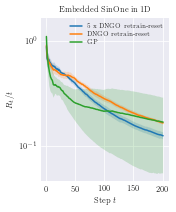

In [5]:
latexify(fig_width=2.3, fig_height=3)
params = {
          'legend.fontsize': 6, # was 10
}
matplotlib.rcParams.update(params)

def get_label(row):
    training_map = {'fixed': 'fixed', 'retrain': 'retrain', 'retrain-reset': 'retrain-reset'}
    model_map = {'gp': 'GP', 'dngo': 'DNGO', 'rand': 'Rand'}
    model = model_map[row.model]
    name = ""
    if row.num_nn > 1:
        name += "{} x ".format(row.num_nn)
    name += model
    if row.model == 'dngo':
        training = training_map[row.nn_training]
        name += ' '
        name += training
    if row.num_mcmc > 0:
        name += ' MCMC'
    return name

df_temp = df[df.group == 'embedding']
df_temp = df_temp[df_temp.embedding == (0,)]
show_regret(df_temp, get_label=get_label, rng=np.random.RandomState(1))('sinone')

plt.title('Embedded SinOne in 1D')
plt.ylabel('$R_t/t$')
plt.xlabel('Step $t$')
plt.savefig('paper/fig/sinone-em-1-cum.pgf')

602d7ae8 5 x DNGO retrain-reset
b28070f5 DNGO retrain-reset
9a6ae4b6 GP
(mean, var, #runs): 0.140493986316 3.74898658852e-05 202
(mean, var, #runs): 0.208514061822 0.000583779489673 202
(mean, var, #runs): 0.148685481771 0.0121396675703 202


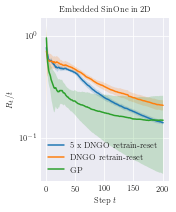

In [6]:
latexify(fig_width=2.3, fig_height=3)

df_temp = df[df.group == 'embedding']
df_temp = df_temp[df_temp.embedding == (0,0)]
show_regret(df_temp, get_label=get_label)('sinone')

plt.title('Embedded SinOne in 2D')
plt.ylabel('$R_t/t$')
plt.xlabel('Step $t$')
plt.savefig('paper/fig/sinone-em-2-cum.pgf')

5af1f524 5 x DNGO retrain-reset
df6c9958 DNGO retrain-reset
695c9cb9 GP
(mean, var, #runs): 0.192368845132 0.00167451520662 202
(mean, var, #runs): 0.336887900639 0.00245098715979 202
(mean, var, #runs): 0.157434447351 0.0130300135072 202


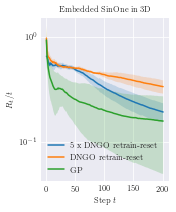

In [7]:
latexify(fig_width=2.3, fig_height=3)

df_temp = df[df.group == 'embedding']
df_temp = df_temp[df_temp.embedding == (0,0,0)]
show_regret(df_temp, get_label=get_label)('sinone')

plt.title('Embedded SinOne in 3D')
plt.ylabel('$R_t/t$')
plt.xlabel('Step $t$')
plt.savefig('paper/fig/sinone-em-3-cum.pgf')

4d9ca039 DNGO fixed with 20 init samples
86081b3c DNGO fixed with 50 init samples
514675e0 DNGO fixed with 100 init samples
fb705763 DNGO fixed with 200 init samples
(mean, var, #runs): 0.480968216496 0.00683499644688 270
(mean, var, #runs): 0.81087370968 0.00268076722625 250
(mean, var, #runs): 1.08952085149 0.00371132002833 300
(mean, var, #runs): 1.52304033149 0.000311484422379 400


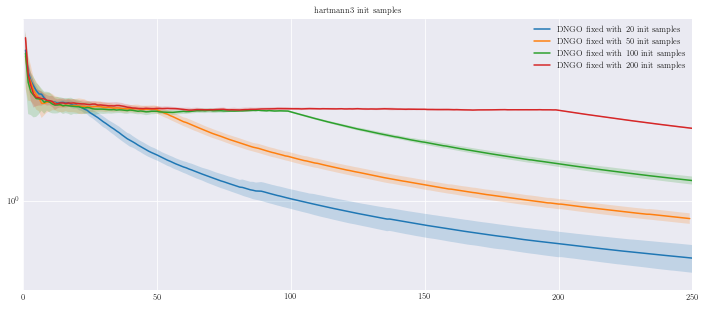

In [8]:
plt.rcParams['figure.figsize'] = (12, 5)

def get_label1(row):
    label = get_label(row)
    return label + " with {} init samples".format(row.n_init)

df_temp = df[df.group == 'n_init']
df_temp = df_temp[(df_temp.n_init != 20) | (df_temp.n_iter == 250)]
df_temp = df_temp.sort_values('n_init')
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.xlim(0, 250)
plt.title('hartmann3 init samples')
plt.savefig('paper/fig/hartmann3-n-init-cum.png')

1659fcee DNGO fixed
9c45ede2 DNGO retrain
f93d839e DNGO retrain-reset
06d4472f GP
(mean, var, #runs): 9.67768715767 2.70716539128 170
(mean, var, #runs): 7.24352400262 0.495009295323 170
(mean, var, #runs): 11.4111495344 0.945275694001 170
(mean, var, #runs): 8.80375458068 0.663064765626 170


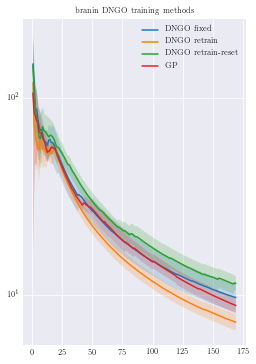

In [9]:
plt.rcParams['figure.figsize'] = (4, 6)
df_temp = df[df.group == 'funcs']
df_temp = df_temp[(df_temp.num_mcmc == 0) & (df_temp.num_nn == 1)]
show_regret(df_temp, get_label=get_label)('branin')
plt.title('branin DNGO training methods')
plt.savefig('paper/fig/branin-nn-training-cum.png')

64ddeb18 DNGO fixed
0980fcf3 DNGO retrain
eaa92612 DNGO retrain-reset
aaa23973 GP
(mean, var, #runs): 0.593342085906 0.00239714976922 170
(mean, var, #runs): 0.450836336594 0.00260017423136 170
(mean, var, #runs): 0.705275686144 0.00397673573796 170
(mean, var, #runs): 0.903160242044 0.000268542312546 170


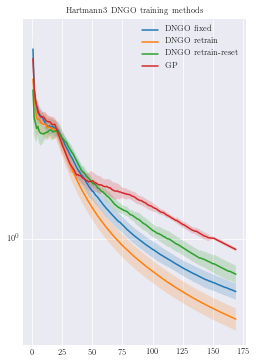

In [10]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[(df_temp.num_mcmc == 0) & (df_temp.num_nn == 1)]
#df_temp = df_temp[(df_temp.nn_training != 'retrain')]
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.title('Hartmann3 DNGO training methods')
plt.savefig('paper/fig/hartmann3-nn-training-cum.png')

a92c6066 5 x DNGO retrain
915c0eb0 5 x DNGO retrain-reset
7819112e DNGO retrain
612c049f DNGO retrain-reset
(mean, var, #runs): 0.953774549061 0.0108358462573 170
(mean, var, #runs): 1.1134200719 0.00651492401623 170
(mean, var, #runs): 1.20029100132 0.00602845131396 170
(mean, var, #runs): 1.24955043281 0.00256653537758 170


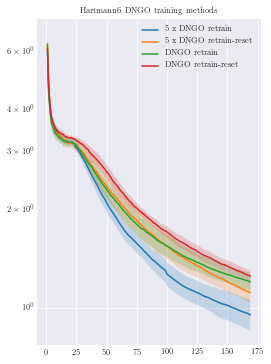

In [11]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[((df_temp.model == 'dngo') & (df_temp.nn_training != 'fixed'))]
show_regret(df_temp, get_label=get_label1)('hartmann6')
plt.title('Hartmann6 DNGO training methods')
plt.savefig('paper/fig/hartmann6-nn-training-cum.png')

4ec2a72c DNGO retrain-reset with 100 epochs
12d2b2c7 DNGO retrain-reset with 1000 epochs
32548bba DNGO retrain-reset with 10000 epochs
(mean, var, #runs): 0.782345905701 0.0010883555884 250
(mean, var, #runs): 0.69287433467 0.00189281709029 250
(mean, var, #runs): 0.607716168926 0.000590385469499 250


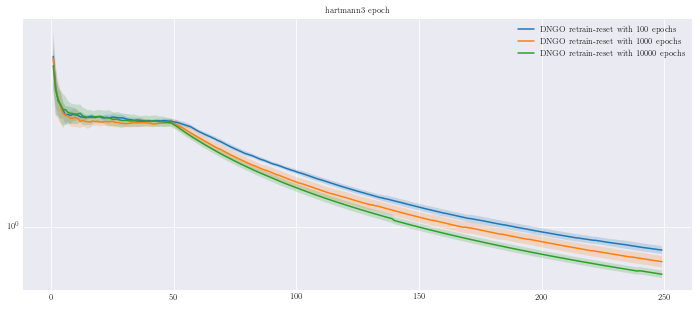

In [12]:
plt.rcParams['figure.figsize'] = (12, 5)

def get_label1(row):
    label = get_label(row)
    return label + " with {} epochs".format(row.epochs)

df_temp = df[df.group == 'epoch']
df_temp = df_temp[df_temp.nn_training == 'retrain-reset']
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.title('hartmann3 epoch')
plt.savefig('paper/fig/hartmann3-epoch-cum.png')

cf86e6f3 DNGO retrain-reset with batch size 10
1caca5f0 DNGO retrain-reset with batch size 40
71004f94 DNGO retrain-reset with batch size 80
1b00d86a DNGO retrain-reset with batch size 160
a48b1e1f DNGO retrain-reset with batch size 320
(mean, var, #runs): 1.43591932314 0.0130324706933 202
(mean, var, #runs): 1.01759992693 0.00247087011293 202
(mean, var, #runs): 0.886506804575 0.00101471599454 202
(mean, var, #runs): 0.820190628535 0.000546818072024 202
(mean, var, #runs): 0.740585220116 0.000169790339524 202


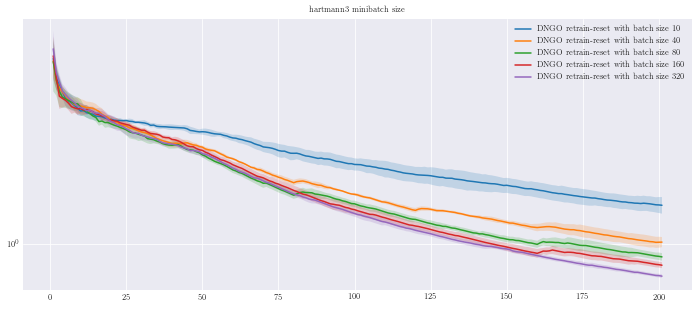

In [13]:
def get_label1(row):
    label = get_label(row)
    return label + ' with batch size {}'.format(row.batch_size)

df_temp = df[df.group == 'minibatch']
df_temp = df_temp[df_temp.batch_size != 20]
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.title('hartmann3 minibatch size')
plt.savefig('paper/fig/hartmann3-minibatch-cum.png')

915c0eb0 5 x DNGO retrain-reset
612c049f DNGO retrain-reset
2ae8e71a GP
51ab30f8 GP MCMC
(mean, var, #runs): 1.1134200719 0.00651492401623 170
(mean, var, #runs): 1.24955043281 0.00256653537758 170
(mean, var, #runs): 1.7633131394 0.00200918837684 170
(mean, var, #runs): 1.8013781169 0.00618757725363 170


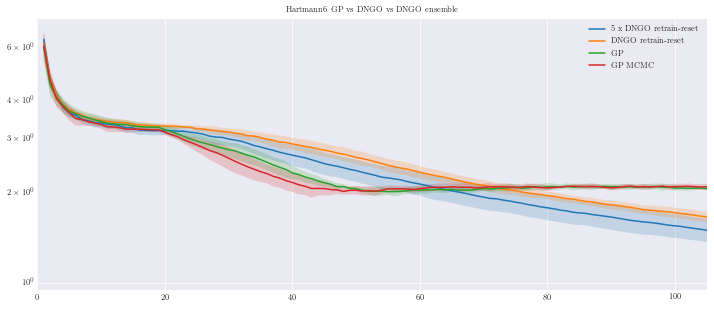

In [14]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[~((df_temp.model == 'dngo') & (df_temp.num_mcmc > 0))]
df_temp = df_temp[((df_temp.model != 'dngo') | (df_temp.nn_training == 'retrain-reset'))]
df_temp = df_temp[(df_temp.nn_training != 'retrain')]
show_regret(df_temp, get_label=get_label1)('hartmann6')
plt.xlim(0,105)
plt.title('Hartmann6 GP vs DNGO vs DNGO ensemble')
plt.savefig('paper/fig/hartmann6-gp-vs-dngo-cum.png')

5045c862 10 x DNGO fixed
a8659690 5 x DNGO fixed MCMC
dcca4821 DNGO fixed
(mean, var, #runs): 1.57549135193 0.0 140
(mean, var, #runs): 1.67362379292 0.0368524308713 170
(mean, var, #runs): 1.95469357258 0.0801412177829 170


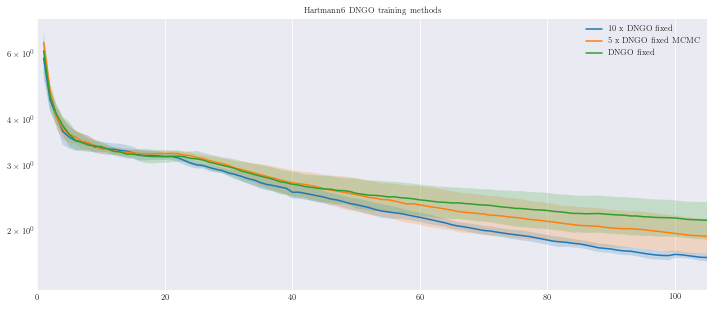

In [15]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[((df_temp.model == 'dngo') & (df_temp.nn_training == 'fixed'))]
show_regret(df_temp, get_label=get_label1)('hartmann6')
plt.xlim(0, 105)
plt.title('Hartmann6 DNGO training methods')
plt.savefig('paper/fig/hartmann6-nn-training-cum.png')

c68aa97f 5 x DNGO fixed
f0061a69 DNGO fixed
59aa7e28 DNGO retrain-reset
43577cbe DNGO retrain-reset MCMC
3ba6b85a GP
6c9d4a28 GP MCMC
4652fbad Rand
(mean, var, #runs): 0.156734877724 0.000166269255525 120
(mean, var, #runs): 0.165932751289 4.29640734329e-05 120
(mean, var, #runs): 0.180162268741 0.000437657760736 102
(mean, var, #runs): 0.177054401709 7.71116675917e-05 102
(mean, var, #runs): 0.16654661659 0.000733226777608 102
(mean, var, #runs): 0.162887536132 0.000139034645735 102
(mean, var, #runs): 0.422669503412 0.000585483116198 120


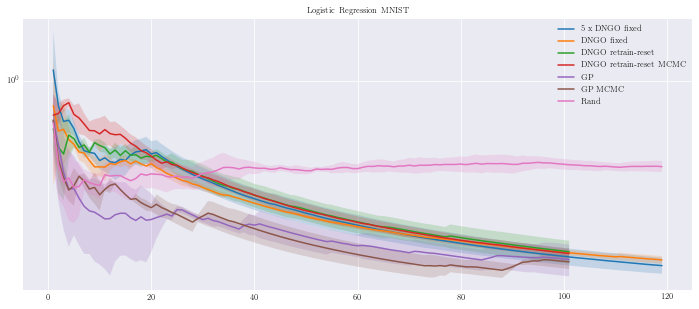

In [16]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
show_regret(df_temp, get_label=get_label1)('lr_mnist')
plt.title('Logistic Regression MNIST')
plt.savefig('paper/fig/lr_mnist-cum.png')

e1434888 DNGO retrain-reset
fac11578 GP
999daa81 Rand
(mean, var, #runs): 0.906735404333 3.98800018803e-10 102
(mean, var, #runs): 0.912363027094 0.0 62
(mean, var, #runs): 0.90706669749 1.2475819915e-09 100


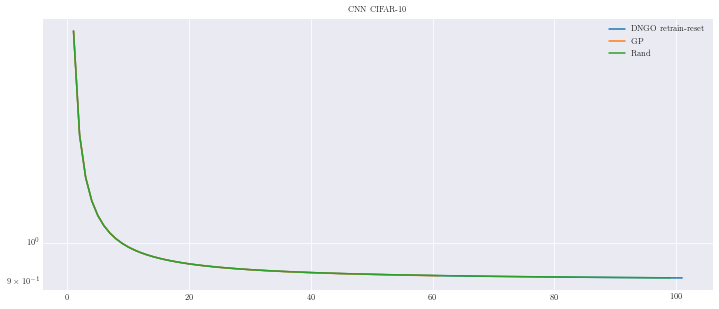

In [17]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[df_temp.init_src == '']
show_regret(df_temp, get_label=get_label1)('cnn_cifar10')
plt.title('CNN CIFAR-10')
plt.savefig('paper/fig/cnn-cifar10-cum.png')

82ca8213 5 x DNGO retrain-reset
92ee64dd DNGO retrain-reset
04e45dbe GP
(mean, var, #runs): 182830.849227 278470458.153 300
(mean, var, #runs): 184057.75892 361510830.843 300
(mean, var, #runs): 259652.536151 358045107.354 300


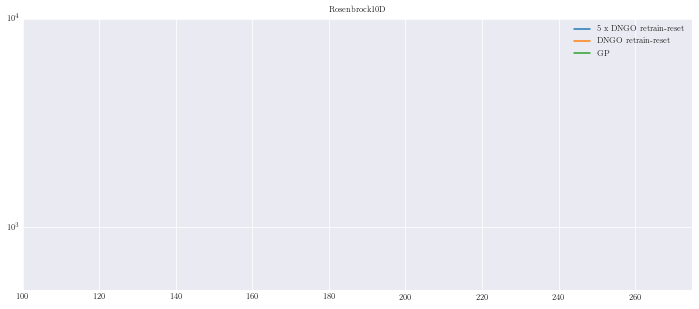

In [18]:
plt.rcParams['figure.figsize'] = (12, 5)
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'highdim']
df_temp = df_temp[df_temp.init_src == '']
df_temp = df_temp[(df_temp.num_mcmc == 0)]
plt.xlim(100, 275)
plt.ylim(500, 10000)
show_regret(df_temp, get_label=get_label1)('rosenbrock8D')
plt.title('Rosenbrock10D')
plt.savefig('paper/fig/rosenbrock10D-cum.png')

import functools
from operator import iand

defaults = dict(
  acq='UCB', 
  activations=('relu', 'relu', 'tanh'), 
  batch_size=1000, 
  dim_basis=50, 
  dim_h1=50, 
  dim_h2=50, 
  #embedding=None, 
  epochs=1000, 
  #group='standard', 
  lr=0.01, 
  model='dngo', 
  #n_init=2, 
  #n_iter=100, 
  #nn_aggregator='median', 
  nn_training='fixed', 
  num_mcmc=0, 
  num_nn=1, 
  #obj_func='branin', 
  #seed=None, 
  #weight_decay=0
)

filters = defaults.copy()
filters.update({
    'nn_training': 'retrain-reset',
    'n_init': 50,
    'weight_decay': 0.0001,
})
for k in ['epochs']:
    del filters[k]
df_temp = df[functools.reduce(iand, [df[k] == v for k,v in filters.items()])]

In [19]:
show_regret(df_temp)

<function __main__.show_regret.<locals>.show_ir(obj_func)>

In [20]:
uid = '7e71cef0'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=False)

KeyError: 'the label [7e71cef0] is not in the [index]'

In [ ]:
bo.model.get_incumbent()

In [ ]:
from src.tests import acc_ir, plot_ir
acc_ir(bo.model.Y, bo.f_opt)

In [ ]:
% matplotlib inline

import argparse
from run import create_model
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

def f(x):
   return np.sinc(x * 10 - 5).sum(axis=-1)[:, None]

args_dict = {
             'model': 'gp',
             # nn
             'activations': ('relu', 'relu', 'tanh'),
             'weight_decay': 0.0001,
             'batch_size': 1000,
             'dim_basis': 50,
             'dim_h1': 50,
             'dim_h2': 50,
             'epochs': 1000,
             'lr': 0.01,
             # GP
             'num_mcmc': 4,
             # Ensemble
             'nn_aggregator': 'average',
             'nn_training': 'fixed',
             'num_nn': 1,
             # Bo
             'acq': 'UCB',
             #'obj_func': 'branin',
             'obj_func': (f, np.array([[0,1]]), 0),
             'embedding': (),
             'seed': 1,
             'n_init': 20,
             'n_iter': 200,}
args = argparse.Namespace(**args_dict)
bo = create_model(args)
bo.run(do_plot=True)

In [ ]:
from src.tests import acc_ir, plot_ir
plot_ir([acc_ir(bo.model.Y, bo.f_opt)])

In [ ]:
uid = 'e8af3045'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=True)
bo.plot_prediction()